# Assignment 3: Ships in Satellite Imagery
In this assignment we will build & train a classical object detector using the Histogram of Orientated Gradients (HOG) Descriptor. We will use this object detector to solve the problem of identifying ships in satellite imagery using the dataset https://www.kaggle.com/rhammell/ships-in-satellite-imagery.  This dataset consists of images of ships and images of NOT ships and is therefore a binary classification problem. The NOT ship categories include partial ships and also linear image features such as roads, jetties, etc., that may be confused with ships.   

In this assignment you will write code for 3 main tasks (in numbered sections below) in order to the build a classical sliding window object detector:


1.   Create an appropriate HOG descriptor for the training images.
2.   Train a Support Vector Machine classifer to perform binary classification on the training set (after the training set is converted)
3. Create a sliding window detector to find ships in larger satellite image scenes.

This assignment demonstrates that classical image processing techniques may be used in preference to deep learning for certain applications. Particularly those that are limited in computational power or require fast execution.

![Ships in Satellite imagery](https://i.imgur.com/tLsSoTz.png)

This lab uses a **kaggle dataset**. **Please read** the [PDF](https://github.com/tonyscan6003/etivities/blob/main/kaggle_data_instructions.pdf) detailing how to setup your PC so that you can use a kaggle dataset within Colab. This assigment contains all the code necessary to read the downloaded kaggle files and to create image and label arrays with test and train splits.

# Dowload Kaggle Dataset.
The following code cells will download the kaggle ship-in-satellite-imagery dataset and unzip the file. (Ensure you have a valid kaggle API token stored on your PC as described in the PDF.)

In [1]:
! pip install -q kaggle
! pip uninstall urllib3
! pip install urllib3
from google.colab import files
files.upload()

Found existing installation: urllib3 2.5.0
Uninstalling urllib3-2.5.0:
  Would remove:
    /usr/local/lib/python3.12/dist-packages/urllib3-2.5.0.dist-info/*
    /usr/local/lib/python3.12/dist-packages/urllib3/*
Proceed (Y/n)? y
  Successfully uninstalled urllib3-2.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.8/129.8 kB 2.0 MB/s eta 0:00:00


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jonny0208","key":"5b176c03898a27c9249bb9550f07992f"}'}

In [2]:
# Use this only if have problems with stale .json file
#!rm kaggle.json
#!rm ~/.kaggle/kaggle.*

In [3]:
#Choose the kaggle.json file that you downloaded
! mkdir ~/.kaggle
#Make directory named kaggle and copy kaggle.json file there.
! cp kaggle.json ~/.kaggle/
#Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json

# Load dataset
! kaggle datasets download rhammell/ships-in-satellite-imagery

!unzip ships-in-satellite-imagery.zip > /dev/null

Dataset URL: https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery
License(s): CC-BY-SA-4.0
 52% 97.0M/185M [00:00<00:00, 1.00GB/s]
100% 185M/185M [00:00<00:00, 612MB/s]  


# HouseKeeping
 Import packages, helper functions to read from URL and import images.

In [4]:

from skimage import feature
from skimage import exposure
from sklearn import svm
from sklearn.model_selection import train_test_split
import numpy as np
import glob
import urllib.request
import cv2
import matplotlib.pyplot as plt


def url_to_image(url):
	user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
	headers ={'User-Agent':user_agent,}
	request=urllib.request.Request(url,None,headers)
	resp = urllib.request.urlopen(request)
	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB
	return temp_image

def read_image(image_url):
    image = url_to_image(image_url)
    x,y,z = np.shape(image)
    # Image is scaled to reduce computation time
    image = cv2.resize(image, dsize=(int(y/sf), int(x/sf)), interpolation=cv2.INTER_CUBIC)
    return image

In [5]:
# Read downloaded file list: Files are comprised of positive (ship) and negaitive (Not ship) examples

pos_img_list = glob.glob('shipsnet/shipsnet/1_*.png')
neg_img_list = glob.glob('shipsnet/shipsnet/0_*.png')


# Read Data
Read data from unzipped downloaded files and create the Training and Test sets.

In [6]:
# Set variables
n = 80 # number of x,y pixels in this image.
n_pts = 4000 # number of points to use (are 4000 in dataset, 1000 positive 3000 negative)

In [7]:
def read_images(img_list):
   train_pos = np.empty([1,n*n])
   # Function to read images from file list
   for i in range(len(img_list)):
      img_path = img_list[i]
      img = cv2.imread(img_path, cv2.IMREAD_COLOR)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      #  store image as row in array
      train_pos = (np.concatenate((train_pos,np.reshape(img, (1, n*n)))) if i>0 else  np.reshape(img, (1, n*n)))
   return train_pos

In [8]:
# Read positive and negative shp images into arrays
pos_img = read_images(pos_img_list)

neg_img = read_images(neg_img_list)


In [9]:
# create corresponding arrays of labels
y_pos_labels = np.ones(len(pos_img_list))
y_neg_labels = np.zeros(len(neg_img_list))

In [10]:
# Combine positive and negative images into one dataset.
dataset_img = np.concatenate((pos_img[0:1000,:],neg_img[0:3000,:]))
dataset_labels = np.append(y_pos_labels,y_neg_labels)

In [11]:
# Training examples
n_train = int(0.7*n_pts)

# Divide into training and test sets with labels
X_train, X_test, y_train, y_test = train_test_split(dataset_img, dataset_labels, train_size=n_train,
                                                    random_state=0,
                                                    stratify=dataset_labels)


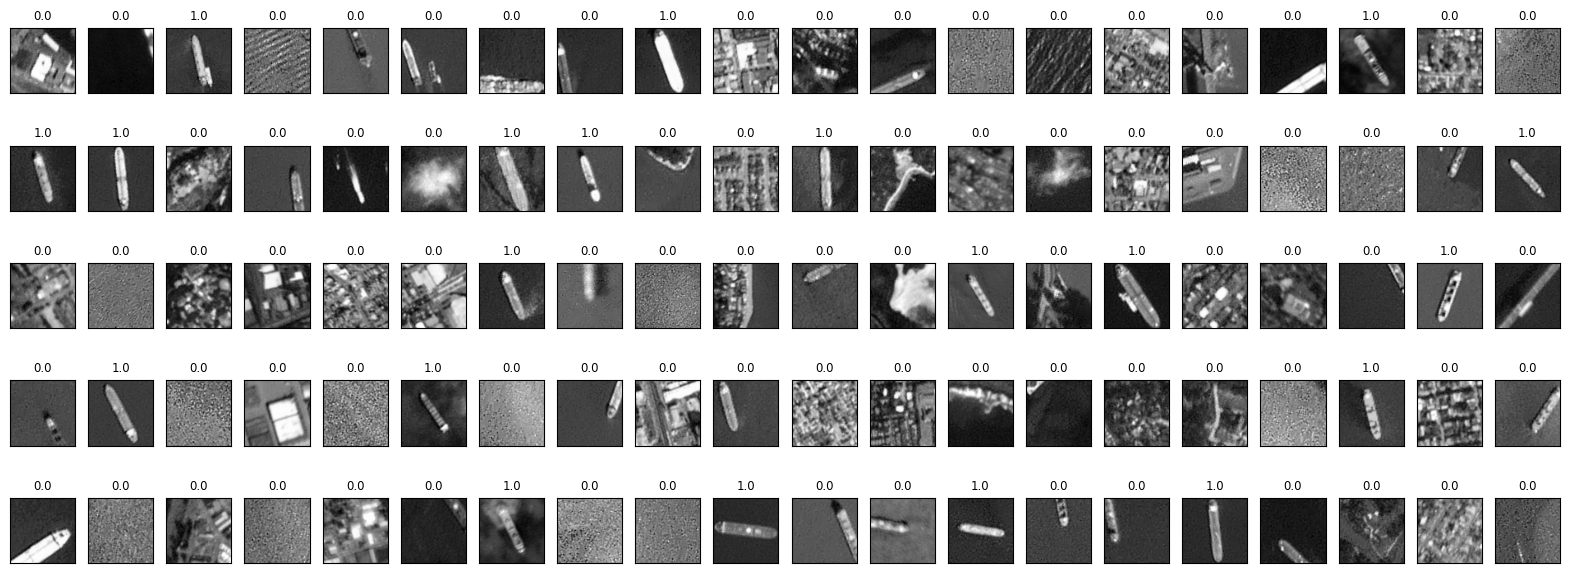

In [12]:
# Plot some examples from the training data
n_plots = 100 # number of plots
fig = plt.figure(figsize=(20, 15))
for i in range(n_plots):
    ax = fig.add_subplot(10, 20, i + 1, xticks=[], yticks=[])
    ax.imshow(np.reshape(X_train[i,0:n*n], (n, n)) ,'gray')
    ax.set_title(y_train[i],
                 fontsize='small')

# 1. HOG Descriptor
In order to obtain the HOG descriptor on each of the image patches during training we use the `feature.hog` command from [skimage](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html).

As in the pedestran detection case (see lesson 4 weeks 10 & 11) we will use the default HOG parameters e.g. 9 orientations in each histogram, 8 x 8 pixels in the cell and 2 x 2 cells per block are used. The size of the detector window in this case is chosen to be the same as the image size = 80 x 80 pixels. This is different to the pedestrian detector window size seen in the lessons.

Assuming that the blocks overlap:  
*   Calculate how many overlapping blocks are in the 80 x 80 detector window
*   Using the number of overlapping blocks and the other information above, determine the length of the HoG feature descriptor in this case.
*   Insert your value for the the length of the HoG feature descriptor in the code cell below.




In [13]:
## INSERT YOUR VALUE FOR n_hog HERE"
n_hog = 2916

In [14]:
# Function that outputs HoG descriptor
def hog_descriptor(img):
    # convert vector to img for HoG processing
    H = feature.hog(img, orientations=9, pixels_per_cell=(8, 8),
	  cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1",
    visualize=False)
    return H

# Function that takes the training/test data and returns array of descriptors
def hog_des_arr(img_arr):
    img_des=np.zeros((len(img_arr),n_hog)) # Empty descriptor array to hold values
    i = 0                                  #pointer
    for img in img_arr:
      img = np.reshape(img[0:n*n], (n, n))  # convert training data vectors to rectangular image
      img_des[i,0:n_hog] = hog_descriptor(img)
      i=i+1
    return img_des

We then convert each of the image patches to it's HOG descriptor. We assign each of these descriptor vectors to the 2D arrays `X_train_des` and `X_test_des` which are now our training & test data.

In [15]:
X_train_des = hog_des_arr(X_train)
X_test_des = hog_des_arr(X_test)

In [16]:
print(np.shape(X_train))
print(np.shape(X_train_des))

(2800, 6400)
(2800, 2916)


 # 2. Training & Test SVM Classifier
 In this section we will train a support vector machine on the data we have converted to it's HOG descriptor. Using descriptors improves classification accuracy compared to using the raw image pixels.

In the code cell below utilise the [sklearn support vector machine](https://scikit-learn.org/stable/modules/svm.html) object and methods to train a support vector machine on the labelled trainig data (X_train_des,y_train).

In [25]:


# Setup Classifier
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0, max_iter=20000)

#Train on Data
clf.fit(X_train_des, y_train)


LinearSVC(max_iter=20000, random_state=0)

Test your classifier using the test dataset and obtain a [classification report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report).


In [26]:
# predict output labels.
y_pred = clf.predict(X_test_des)


In [27]:
# Classification Report
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       900
         1.0       0.96      0.97      0.97       300

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200

Accuracy: 0.9833333333333333


We can plot some example from the test set using the code cell below.

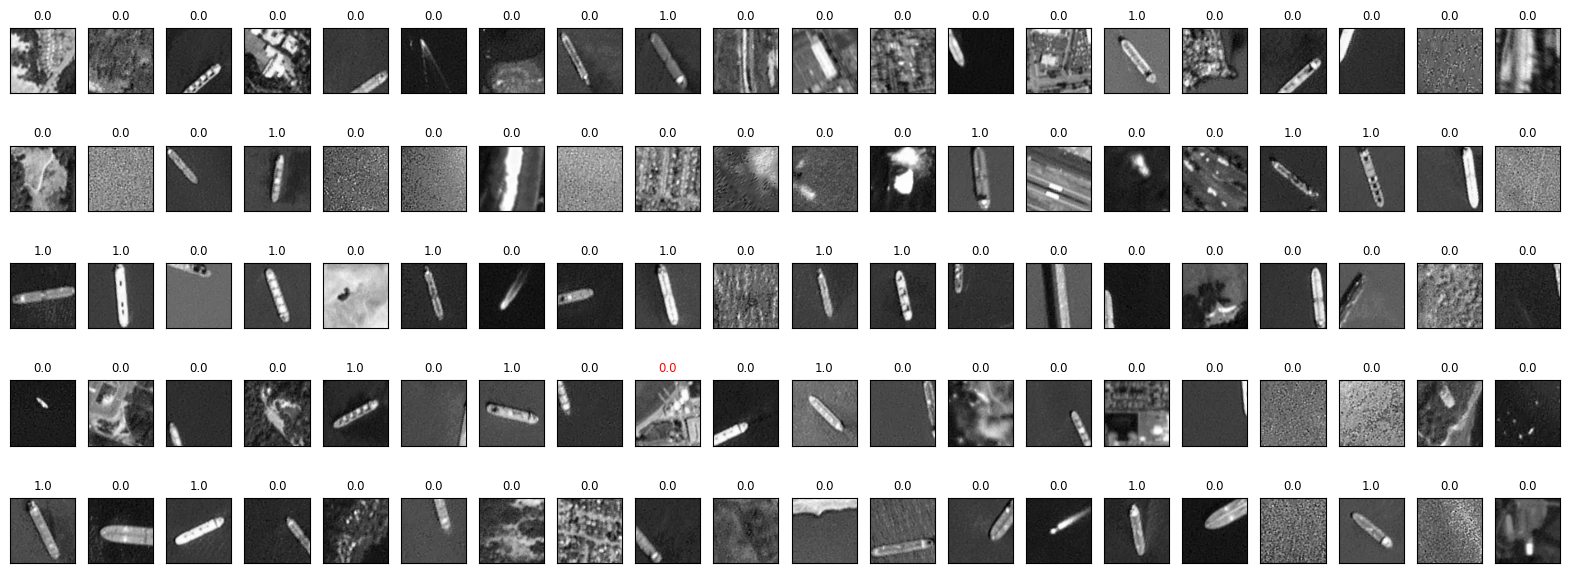

In [36]:


n_plots = 30 # number of plots
fig = plt.figure(figsize=(20, 15))
for i in range(100):
    ax = fig.add_subplot(10, 20, i + 1, xticks=[], yticks=[])
    ax.imshow( np.reshape(X_test[i,0:n*n], (n, n)) ,'gray')
    color = ('black' if y_pred[i] == y_test[i] else 'red')
    ax.set_title(y_test[i],
                 fontsize='small', color=color)

# 3. Use Classifier as a basic object Detector with a sliding window.
Now that we have a trained SVM and HoG descriptor, these components can be used as the basis of a sliding window detector. The sliding window can be used to automatically detect & mark the location of ships in a large satellite image view.

**Import scene:** We can perform object detection of ships in the scene imported in the code cell below. You can use grey scale version of the image gray_img in your sliding window detector, bounding boxes can be applied to the colour version of the image.

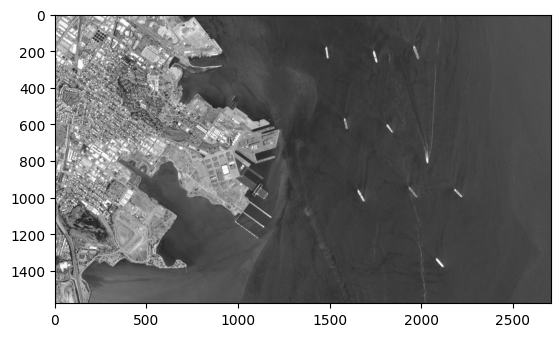

In [92]:

img_path = 'scenes/scenes/sfbay_3.png'
col_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
gray_img = cv2.cvtColor(col_img, cv2.COLOR_BGR2GRAY)
plt.imshow( gray_img ,'gray')




In the code cell below you can code the sliding window function `sliding_window` which operates on the scene image. You can run your detector over the entire image pixel range, there is no need to make any special accomodation for the image border. The function outputs the array m x 4, where m is the number of bounding boxes detected.


*Step Size*
> The sliding window which is the same size as our training images `n` = 80, is moved around the image according to the value of the parameter `step_size` which you can set to an optimimum size. Larger step values may cause an object to be missed, however using a larger step size will increase the speed of execution which is useful to debug your algorithm. When a smaller step size is used, multiple detections of the same object can occur.

*Coordinate Systems*

> The greyscale input image that we are applying our sliding window detector to is a matrix. The elements of this matrix are accessed as (row,column). In order to successfully plot the bouding box using OpenCV rectangle commands, the bounding boxes must be output in a format [x1,y1,x2,y2] where x1,y1 correspond to the top left hand side corner of the bouding box and x2,y2 the bottom right corner. Thus the x coordinate of the bounding box corresponds to the column of the matrix and the y coordinate the rows. The origin (0,0) in the coordinate system used by OpenCV is the top left of the image.

*Non Maximal Supression*

>  We can use the `non_max_supression` function from the `imutils` package to remove overlapping detections. (This is already implemented in the code cell below that displays the bouding boxes you find)  

*Image Pyramid*

> We will not include a image pyramid in our object detector. As the test scene images are taken from fixed position satellite images similar to the training patches, there is no need to adjust the scale of the image.

In [93]:
# Detection window size and stride
windowSize = (n, n)
step_size = 13 #13 working okay...


### COMPLETE THE SLIDING WINDOW FUNCTION HERE ###

def sliding_window(image):
    """
    image: input satellite image of arbitary size
    found_boxes: m x 4 array of output bounding boxes.
                 Each row corresponds to a bounding box [x1,y2,x2,y2]
                 (see note on coordinate system above)
    """
    H, W = image.shape[:2]
    boxes = []

    for y in range(0, H - n + 1, step_size):        # y = rows
        for x in range(0, W - n + 1, step_size):    # x = cols
            patch = image[y:y+n, x:x+n]
            des = hog_descriptor(patch).reshape(1, -1)

            # Use decision_function when available (LinearSVC), threshold at 0
            if hasattr(clf, "decision_function"):
                score = float(np.ravel(clf.decision_function(des))[0])
                if score > 0.75:
                    boxes.append([x, y, x + n - 1, y + n - 1])
            else:
                pred = int(clf.predict(des)[0])
                if pred == 1:
                    boxes.append([x, y, x + n - 1, y + n - 1])

    found_boxes = np.array(boxes, dtype=int) if boxes else np.zeros((0, 4), dtype=int)
    return found_boxes


You can run your function to output all the bounding boxes from the detections made by the classifier in the image.

In [94]:

found_boxes = sliding_window(gray_img)


The non_max_supression function from the imutils package is used to remove overlapping boxes. The boxes are overlaid on the color version of the satellite image.

Before suppression, we had 22 bounding boxes, after suppression we have 18


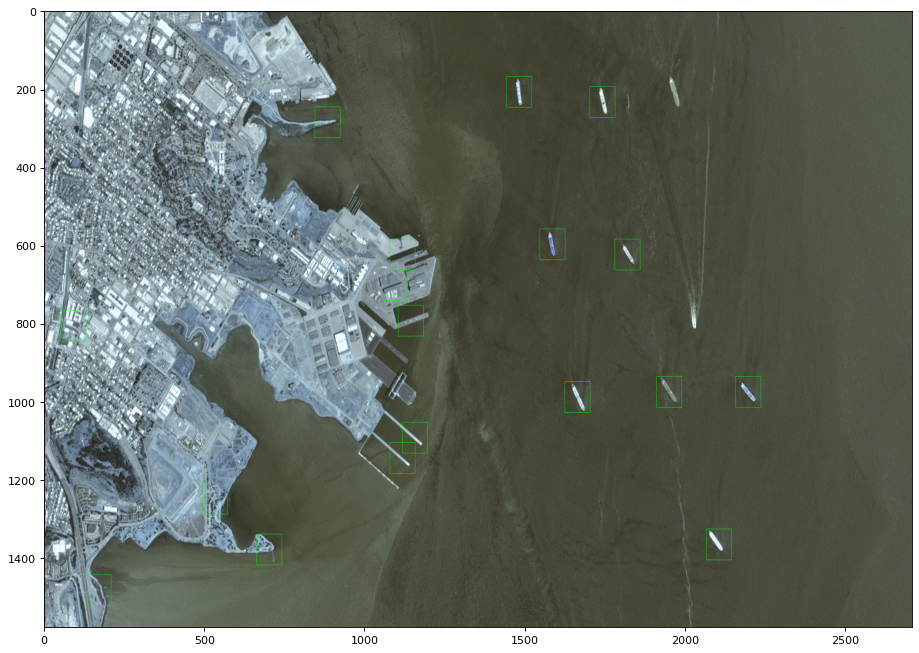

In [95]:
from imutils.object_detection import non_max_suppression

#Bounding box parameters
#greenColor = (0, 255, 0)
#lineThickness = 4

# run non-max suppression on these based on an overlay op 65%
nmsBoundingBoxes = non_max_suppression(found_boxes, probs=None, overlapThresh=0.65)

print ("Before suppression, we had {} bounding boxes, after suppression we have {}".format(len(found_boxes), len(nmsBoundingBoxes)))

greenColor = (0, 255, 0)
lineThickness = 1
# draw the final bounding boxes
for (xA, yA, xB, yB) in nmsBoundingBoxes:
    cv2.rectangle(col_img, (xA, yA), (xB, yB), greenColor, lineThickness)

# Plot figures
plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(col_img, aspect='auto')
plt.show()